# Sequence Model with Attention for Addition Learning

- In this lecture note, we demonstrate a simple sequence-to-sequence model for addition learning.
- The inputs are sequences of two numbers adding together; the outputs are the correct answers, i.e., the sum of the two numbers.
- This task is to simulate the machine translation task.
- In particular, we demonstrate the uses of two types of Attention layers from `tensorflow.keras.layers`:
  - `Attention` (Luong attention)
  - `AdditiveAttention` (Bahdanau attention)

:::{warning}
- Please update `tensorflow` to the most recent version (v2+).
- In the `tensorflow-nightly`, `MultiheadedAttention` is available. 
:::

## Set up Dependencies

In [1]:
import re
import tensorflow
import numpy as np
from random import randint
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, SimpleRNN, Bidirectional, Concatenate, TimeDistributed, RepeatVector, Attention, AdditiveAttention, GlobalAveragePooling1D
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [2]:
print('Tensorflow Version: ', tensorflow.__version__)

Tensorflow Version:  2.4.1


## Deep Learning Hyperparameters

In [3]:
batch_size = 128  # Batch size for training.
epochs = 10  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

## Data Preprocessing

- The dataset is from the book, Deep Learning 2: 用Python進行自然語言處理的理論實作.
- Several preprocessing steps have been done by the data provider:
    - All the input sequences have been padded to unigram lengths.
    - All the target sequences have been added with sequence-initial and sequence-ending characters `_`.

In [4]:
data_path = '../../../RepositoryData/data/deep-learning-2/addition.txt'

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

input_texts = [l.split('_')[0] for l in lines]
target_texts = [l.split('_')[-1].strip() for l in lines]

target_texts = ['_' + sent + '_' for sent in target_texts]

np.random.seed(123)

inds = np.arange(len(input_texts))
np.random.shuffle(inds)

print(input_texts[:5])
print(target_texts[:5])
print('Data Size:', len(input_texts))

['16+75  ', '52+607 ', '75+22  ', '63+22  ', '795+3  ']
['_91_', '_659_', '_97_', '_85_', '_798_']
Data Size: 50001


## Train-Test Split

In [5]:
train_test_ratio = 0.9
train_size = int(round(len(lines) * train_test_ratio))
train_inds = inds[:train_size]
test_inds = inds[train_size:]

tr_input_texts = [input_texts[ti] for ti in train_inds]
tr_target_texts = [target_texts[ti] for ti in train_inds]

ts_input_texts = [input_texts[ti] for ti in test_inds]
ts_target_texts = [target_texts[ti] for ti in test_inds]

In [6]:
tr_input_texts[:10]

['27+673 ',
 '153+27 ',
 '93+901 ',
 '243+678',
 '269+46 ',
 '235+891',
 '46+290 ',
 '324+947',
 '721+49 ',
 '535+7  ']

In [7]:
tr_target_texts[:10]

['_700_',
 '_180_',
 '_994_',
 '_921_',
 '_315_',
 '_1126_',
 '_336_',
 '_1271_',
 '_770_',
 '_542_']

In [8]:
print('Number of Samples:', len(lines))
print('Number of Samples in Training:', len(tr_input_texts))
print('Number of Samples in Testing:', len(ts_input_texts))

Number of Samples: 50001
Number of Samples in Training: 45001
Number of Samples in Testing: 5000


## Data Preprocessing

![](../images/text-seq-onehot-embedding.jpeg)

### Text to Sequences

- Tokenization of input and target texts invovles the following important steps:
    - Create a `Tokenizer`
    - Fit the `Tokenizer` on the training sets
    - Tokenize input and target texts of the training set into sequences
    - Identify the maxlen of the input and target texts (Redundant for this dataset)
    - Pad input and text sequences to uniform lengths (Redundant for this dataset)

In [9]:
# """ Defining tokenizers """
input_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK',
                                                     char_level=True)
input_tokenizer.fit_on_texts(tr_input_texts)
encoder_input_sequences = input_tokenizer.texts_to_sequences(tr_input_texts)
input_maxlen = np.max([len(l) for l in encoder_input_sequences])
encoder_input_sequences = pad_sequences(encoder_input_sequences,
                                        padding='post',
                                        maxlen=input_maxlen)

target_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK',
                                                      char_level=True)
target_tokenizer.fit_on_texts(tr_target_texts)
target_sequences = target_tokenizer.texts_to_sequences(tr_target_texts)
target_maxlen = np.max([len(l) for l in target_sequences])
target_sequences = pad_sequences(target_sequences,
                                 padding='post',
                                 maxlen=target_maxlen)

In [10]:
# Shapes of Input and Target Sequences
print(encoder_input_sequences.shape)
print(target_sequences.shape)

(45001, 7)
(45001, 6)


:::{note}
The plus 1 for vocabulary size is to include the padding character, whose index is the reserved `0`.
:::

In [11]:
# ### vocab size
input_vsize = max(input_tokenizer.index_word.keys()) + 1
target_vsize = max(target_tokenizer.index_word.keys()) + 1

In [12]:
print(input_vsize)
print(target_vsize)

14
13


In [13]:
tr_input_texts[:5]

['27+673 ', '153+27 ', '93+901 ', '243+678', '269+46 ']

In [14]:
encoder_input_sequences[:5]

array([[11, 12,  3,  9, 12,  7,  2],
       [10,  8,  7,  3, 11, 12,  2],
       [ 4,  7,  3,  4, 13, 10,  2],
       [11,  5,  7,  3,  9, 12,  6],
       [11,  9,  4,  3,  5,  9,  2]], dtype=int32)

In [15]:
tr_target_texts[:5]

['_700_', '_180_', '_994_', '_921_', '_315_']

In [16]:
target_sequences[:5]

array([[ 2,  5, 12, 12,  2,  0],
       [ 2,  3, 11, 12,  2,  0],
       [ 2,  8,  8,  9,  2,  0],
       [ 2,  8,  4,  3,  2,  0],
       [ 2,  7,  3, 10,  2,  0]], dtype=int32)

- Input and Output Sequences for Decoder
    - Decoder input and output sequences have one time-step difference (i.e., the decoder's output at $t-1$ is the decoder's input at $t$)
    - We create decoder input and output sequences as different sets of data.

In [17]:
decoder_input_sequences = np.zeros((len(target_sequences), target_maxlen - 1),
                                   dtype='float32')
decoder_output_sequences = np.zeros((len(target_sequences), target_maxlen - 1),
                                    dtype='float32')

for i, seq in enumerate(target_sequences):
    for t, char in enumerate(seq):
        if t < len(seq) - 1:
            decoder_input_sequences[i, t] = char
        if t > 0:
            decoder_output_sequences[i, t - 1] = char

In [18]:
decoder_input_sequences[:5]

array([[ 2.,  5., 12., 12.,  2.],
       [ 2.,  3., 11., 12.,  2.],
       [ 2.,  8.,  8.,  9.,  2.],
       [ 2.,  8.,  4.,  3.,  2.],
       [ 2.,  7.,  3., 10.,  2.]], dtype=float32)

In [19]:
decoder_output_sequences[:5]

array([[ 5., 12., 12.,  2.,  0.],
       [ 3., 11., 12.,  2.,  0.],
       [ 8.,  8.,  9.,  2.,  0.],
       [ 8.,  4.,  3.,  2.,  0.],
       [ 7.,  3., 10.,  2.,  0.]], dtype=float32)

### Sequences to One-Hot Encoding

- This step converts the sequence token into a one-hot encoding.
- This step would render the text representation of the entire training data from 2D (batch_size, sequence_length) to 3D tensors (batch_size, sequence_length, vocab_size).

:::{note}
For neural machine translations, the vocabulary sizes of the input and target languages are usually very large. It is more effective to implement an **Embedding** layer to convert sequences (integers) into embeddings, rather than one-hot encodings.

For this tutorial, we have a limited vocabulary size (only digits and math symbols). One-hot encodings should be fine.
:::

In [20]:
print(encoder_input_sequences.shape)
print(decoder_input_sequences.shape)
print(decoder_output_sequences.shape)

(45001, 7)
(45001, 5)
(45001, 5)


In [21]:
encoder_input_onehot = to_categorical(encoder_input_sequences,
                                      num_classes=input_vsize)
decoder_input_onehot = to_categorical(decoder_input_sequences,
                                      num_classes=target_vsize)
decoder_output_onehot = to_categorical(decoder_output_sequences,
                                       num_classes=target_vsize)

In [22]:
print(encoder_input_onehot.shape)
print(decoder_input_onehot.shape)
print(decoder_output_onehot.shape)

(45001, 7, 14)
(45001, 5, 13)
(45001, 5, 13)


### Token Indices

In [23]:
""" Index2word """
enc_index2word = dict(
    zip(input_tokenizer.word_index.values(),
        input_tokenizer.word_index.keys()))
dec_index2word = dict(
    zip(target_tokenizer.word_index.values(),
        target_tokenizer.word_index.keys()))

In [24]:
enc_index2word

{1: 'UNK',
 2: ' ',
 3: '+',
 4: '9',
 5: '4',
 6: '8',
 7: '3',
 8: '5',
 9: '6',
 10: '1',
 11: '2',
 12: '7',
 13: '0'}

In [25]:
dec_index2word

{1: 'UNK',
 2: '_',
 3: '1',
 4: '2',
 5: '7',
 6: '6',
 7: '3',
 8: '9',
 9: '4',
 10: '5',
 11: '8',
 12: '0'}

In [26]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

## Define Model Architecture

- Sequence-to-Sequence can go from simple RNNs to complex models with attention mechanisms.
- In this tutorial, we will try the following:
    - Sequence-to-sequence model with vanila RNN Encoder and Decoder
    - Sequence-to-sequence model with bidirectional RNN Encoder
    - Sequence-to-sequence model with peeky Decoder
    - Sequence-to-sequence model with attention-based Decoder

## Model 1 (Vanilla RNN)

![](../images/seq2seq-vanilla-rnn.jpeg)

### Define Model

- In the training stage, we feed the decoder the correct answer at each timestep as the input sequence. 
- In the real testing stage, the decoder will take the hidden state from the previous timestep as the input sequence.
- This type of training is referred to as **teacher forcing** learning strategy. This can help the model converge more effectively..

In [27]:
# Define Model Inputs
encoder_inputs = Input(shape=(input_maxlen, input_vsize),
                       name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen - 1, target_vsize),
                       name='decoder_inputs')

# Encoder RNN
encoder_rnn = SimpleRNN(latent_dim,
                        return_sequences=True,
                        return_state=True,
                        name='encoder_rnn')
_, encoder_state = encoder_rnn(encoder_inputs)
## first return is the hidden states of all timesteps of encoder
## second return is the last hidden state of encoder

# Decoder RNN
## using `encoder_state` (last h) as initial state.
## using `decoder_inputs` for teacher forcing learning
decoder_rnn = SimpleRNN(latent_dim,
                        return_sequences=True,
                        return_state=True,
                        name='decoder_rnn')
decoder_out, _ = decoder_rnn(decoder_inputs, initial_state=encoder_state)

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_out)

# Full model
full_model1 = Model(inputs=[encoder_inputs, decoder_inputs],
                    outputs=decoder_pred)
full_model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 14)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 13)]      0                                            
__________________________________________________________________________________________________
encoder_rnn (SimpleRNN)         [(None, 7, 256), (No 69376       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_rnn (SimpleRNN)         [(None, 5, 256), (No 69120       decoder_inputs[0][0]             
                                                                 encoder_rnn[0][1]            

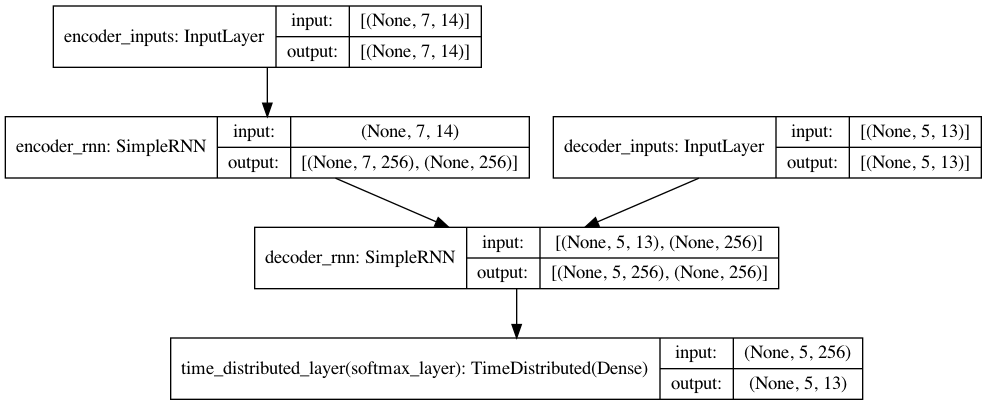

In [28]:
plot_model(full_model1, show_shapes=True)

### Training

In [29]:
# Run training
full_model1.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
history1 = full_model1.fit([encoder_input_onehot, decoder_input_onehot],
                           decoder_output_onehot,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_split=0.2)

Epoch 1/10
282/282 [==============================] - 6s 17ms/step - loss: 1.4500 - accuracy: 0.4757 - val_loss: 1.1923 - val_accuracy: 0.5528
Epoch 2/10
282/282 [==============================] - 4s 13ms/step - loss: 1.1410 - accuracy: 0.5736 - val_loss: 1.0130 - val_accuracy: 0.6151
Epoch 3/10
282/282 [==============================] - 4s 13ms/step - loss: 0.9584 - accuracy: 0.6359 - val_loss: 0.8551 - val_accuracy: 0.6633
Epoch 4/10
282/282 [==============================] - 4s 13ms/step - loss: 0.7685 - accuracy: 0.7039 - val_loss: 0.6541 - val_accuracy: 0.7441
Epoch 5/10
282/282 [==============================] - 4s 13ms/step - loss: 0.6053 - accuracy: 0.7666 - val_loss: 0.5303 - val_accuracy: 0.7926
Epoch 6/10
282/282 [==============================] - 4s 13ms/step - loss: 0.4879 - accuracy: 0.8160 - val_loss: 0.4388 - val_accuracy: 0.8321
Epoch 7/10
282/282 [==============================] - 4s 13ms/step - loss: 0.3990 - accuracy: 0.8510 - val_loss: 0.3904 - val_accuracy: 0.8448

## Model 2 (GRU)

- In Model 2, we replace vanilla RNN with GRU, which deals with the issue of long-distance dependencies between sequences.

### Define Model

In [30]:
# Define Model Inputs
encoder_inputs = Input(shape=(input_maxlen, input_vsize),
                       name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen - 1, target_vsize),
                       name='decoder_inputs')

# Encoder GRU
encoder_gru = GRU(latent_dim,
                  return_sequences=True,
                  return_state=True,
                  name='encoder_gru')
_, encoder_state = encoder_gru(encoder_inputs)

# Decoder GRU, using `encoder_state` (last h) as initial state.
decoder_gru = GRU(latent_dim,
                  return_sequences=True,
                  return_state=True,
                  name='decoder_gru')
decoder_out, _ = decoder_gru(decoder_inputs, initial_state=encoder_state)

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_out)

# Full model
full_model2 = Model(inputs=[encoder_inputs, decoder_inputs],
                    outputs=decoder_pred)
full_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 14)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 13)]      0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(None, 7, 256), (No 208896      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(None, 5, 256), (No 208128      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

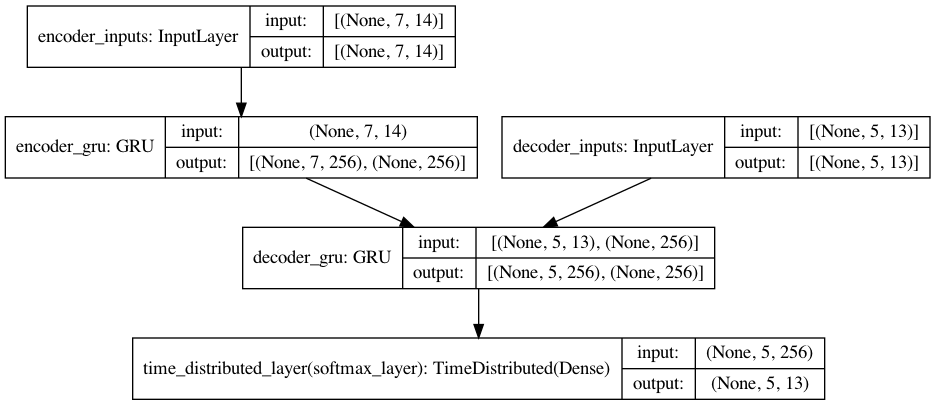

In [31]:
plot_model(full_model2, show_shapes=True)

### Training

In [32]:
# Run training
full_model2.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
history2 = full_model2.fit([encoder_input_onehot, decoder_input_onehot],
                           decoder_output_onehot,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_split=0.2)

Epoch 1/10
282/282 [==============================] - 14s 40ms/step - loss: 1.6989 - accuracy: 0.4125 - val_loss: 1.3796 - val_accuracy: 0.4834
Epoch 2/10
282/282 [==============================] - 10s 37ms/step - loss: 1.3603 - accuracy: 0.4873 - val_loss: 1.2371 - val_accuracy: 0.5284
Epoch 3/10
282/282 [==============================] - 10s 37ms/step - loss: 1.1844 - accuracy: 0.5522 - val_loss: 1.0387 - val_accuracy: 0.5996
Epoch 4/10
282/282 [==============================] - 10s 37ms/step - loss: 1.0148 - accuracy: 0.6150 - val_loss: 0.9530 - val_accuracy: 0.6336
Epoch 5/10
282/282 [==============================] - 10s 37ms/step - loss: 0.9087 - accuracy: 0.6550 - val_loss: 0.8163 - val_accuracy: 0.6880
Epoch 6/10
282/282 [==============================] - 10s 37ms/step - loss: 0.7944 - accuracy: 0.6987 - val_loss: 0.7497 - val_accuracy: 0.7173
Epoch 7/10
282/282 [==============================] - 11s 38ms/step - loss: 0.7310 - accuracy: 0.7238 - val_loss: 0.7045 - val_accuracy:

## Model 3 (Birdirectional)

- In Model 3, we implement a bi-directional sequence model for Decoder.

![](../images/seq2seq-bidirectional.jpeg)

### Define Model

In [33]:
# Define Model Inputs
encoder_inputs = Input(shape=(input_maxlen, input_vsize),
                       name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen - 1, target_vsize),
                       name='decoder_inputs')

# Encoder GRU
encoder_gru = Bidirectional(
    GRU(latent_dim,
        return_sequences=True,
        return_state=True,
        name='encoder_gru'))
_, encoder_state_fwd, encoder_state_bwd = encoder_gru(encoder_inputs)

# Combine forward and backward state (last h's) from encoder
encoder_state = Concatenate(axis=-1)([encoder_state_fwd, encoder_state_bwd])

# Decoder GRU, using `encoder_state`, but the latent dim needs to be doubled because we use two last states from the bidirectional encoder
decoder_gru = GRU(latent_dim * 2,
                  return_sequences=True,
                  return_state=True,
                  name='decoder_gru')
decoder_out, _ = decoder_gru(decoder_inputs, initial_state=encoder_state)

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_out)

# Full model
full_model3 = Model(inputs=[encoder_inputs, decoder_inputs],
                    outputs=decoder_pred)
full_model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 14)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 7, 512), (No 417792      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 13)]      0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           bidirectional[0][1]              
                                                                 bidirectional[0][2]        

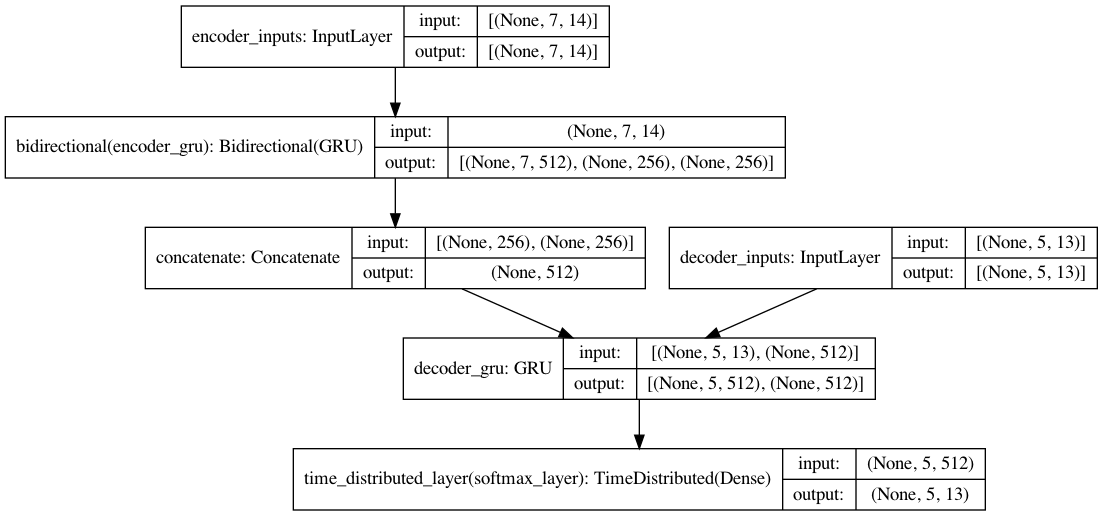

In [34]:
plot_model(full_model3, show_shapes=True)

### Training

In [35]:
# Run training
full_model3.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
history3 = full_model3.fit([encoder_input_onehot, decoder_input_onehot],
                           decoder_output_onehot,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_split=0.2)

Epoch 1/10
282/282 [==============================] - 32s 100ms/step - loss: 1.6461 - accuracy: 0.4239 - val_loss: 1.3431 - val_accuracy: 0.4953
Epoch 2/10
282/282 [==============================] - 29s 102ms/step - loss: 1.2741 - accuracy: 0.5192 - val_loss: 1.0240 - val_accuracy: 0.6093
Epoch 3/10
282/282 [==============================] - 30s 106ms/step - loss: 0.9749 - accuracy: 0.6281 - val_loss: 0.8235 - val_accuracy: 0.6768
Epoch 4/10
282/282 [==============================] - 30s 106ms/step - loss: 0.7720 - accuracy: 0.7028 - val_loss: 0.6697 - val_accuracy: 0.7371
Epoch 5/10
282/282 [==============================] - 29s 103ms/step - loss: 0.6215 - accuracy: 0.7636 - val_loss: 0.5516 - val_accuracy: 0.7859
Epoch 6/10
282/282 [==============================] - 29s 104ms/step - loss: 0.4765 - accuracy: 0.8197 - val_loss: 0.2602 - val_accuracy: 0.9048
Epoch 7/10
282/282 [==============================] - 28s 100ms/step - loss: 0.2115 - accuracy: 0.9279 - val_loss: 0.1135 - val_ac

## Model 4 (Peeky Decoder)

- In the previous models, Decoder only utilizes the last hidden state of Encoder for the decoding of the first output. As for the subsequent decoding timesteps, Decoder does not have the information from Encoder.
- In Model 4, we implement a **peeky** Decoder. This strategy allows the Decoder to access the information (last hidden state) of the Encoder in the decoding of every timestep.

![](../images/seq2seq-peeky.jpeg)

### Define Model

In [36]:
# Define Model Inputs
encoder_inputs = Input(shape=(input_maxlen, input_vsize),
                       name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen - 1, target_vsize),
                       name='decoder_inputs')

# Encoder GRU
encoder_gru = Bidirectional(
    GRU(latent_dim,
        return_sequences=True,
        return_state=True,
        name='encoder_gru'))
_, encoder_state_fwd, encoder_state_bwd = encoder_gru(encoder_inputs)

# Combine forward and backward state (last h's) from encoder
encoder_state = Concatenate(axis=-1)([encoder_state_fwd, encoder_state_bwd])


# Repeat the last-hidden-state of Encoder
encoder_state_repeated = RepeatVector(target_maxlen - 1)(encoder_state)

## Concatenate every decoder input with the encoder_state
decoder_inputs_peeky = Concatenate(axis=2)(
    [decoder_inputs, encoder_state_repeated])

# Decoder GRU, using `encoder_state`, but the latent dim needs to be doubled because we use two last states from the bidirectional encoder
decoder_gru = GRU(latent_dim * 2,
                  return_sequences=True,
                  return_state=True,
                  name='decoder_gru')
decoder_out, _ = decoder_gru(decoder_inputs_peeky, initial_state=encoder_state)

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_out)

# Full model
full_model4 = Model(inputs=[encoder_inputs, decoder_inputs],
                    outputs=decoder_pred)

full_model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 14)]      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 7, 512), (No 417792      encoder_inputs[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][2]            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 13)]      0                                      

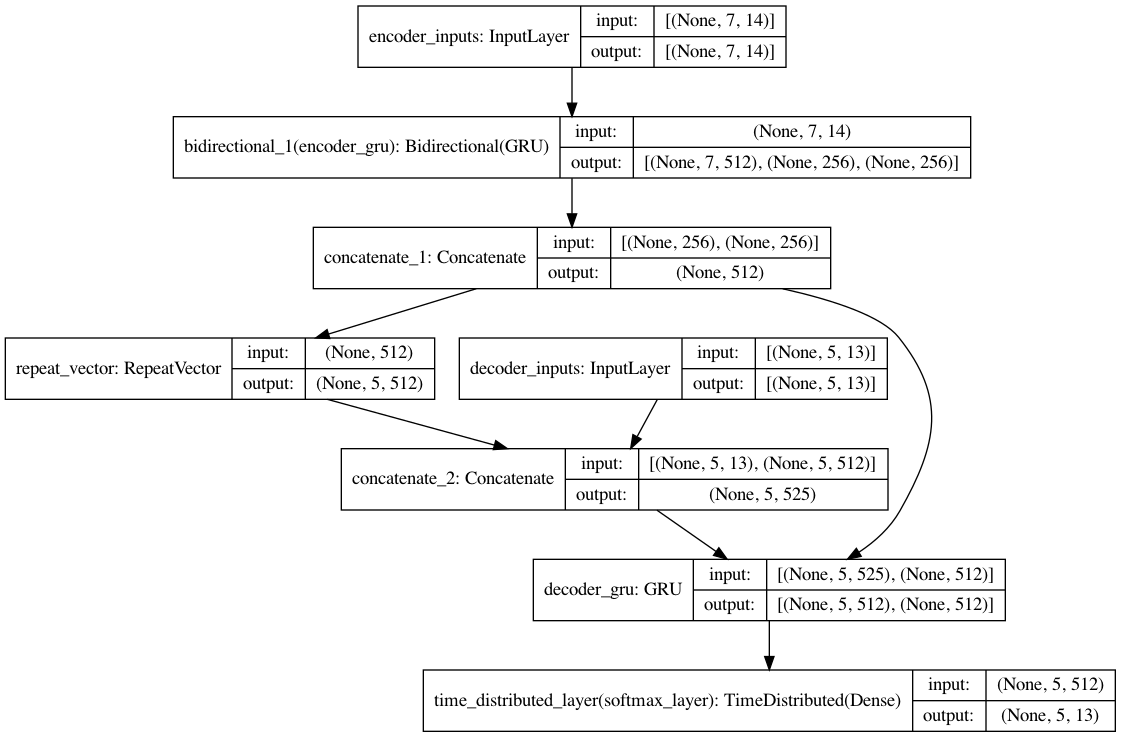

In [37]:
plot_model(full_model4, show_shapes=True)

### Training

In [38]:
# Run training
full_model4.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
history4 = full_model4.fit([encoder_input_onehot, decoder_input_onehot],
                           decoder_output_onehot,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_split=0.2)

Epoch 1/10
282/282 [==============================] - 45s 142ms/step - loss: 1.6275 - accuracy: 0.4324 - val_loss: 1.3418 - val_accuracy: 0.4982
Epoch 2/10
282/282 [==============================] - 38s 135ms/step - loss: 1.2627 - accuracy: 0.5272 - val_loss: 1.0044 - val_accuracy: 0.6211
Epoch 3/10
282/282 [==============================] - 41s 144ms/step - loss: 0.9224 - accuracy: 0.6503 - val_loss: 0.7382 - val_accuracy: 0.7228
Epoch 4/10
282/282 [==============================] - 41s 144ms/step - loss: 0.6932 - accuracy: 0.7401 - val_loss: 0.5802 - val_accuracy: 0.7796
Epoch 5/10
282/282 [==============================] - 41s 144ms/step - loss: 0.4974 - accuracy: 0.8125 - val_loss: 0.2560 - val_accuracy: 0.9150
Epoch 6/10
282/282 [==============================] - 39s 139ms/step - loss: 0.2022 - accuracy: 0.9385 - val_loss: 0.1113 - val_accuracy: 0.9737
Epoch 7/10
282/282 [==============================] - 44s 158ms/step - loss: 0.1014 - accuracy: 0.9744 - val_loss: 0.1051 - val_ac

## Model 5 (Attention)

- In Model 5, we implement an Attention-based Decoder.
- This Attention mechanism allows the Decoder to use all the information (all hidden states of all timesteps) of the Encoder.

![](../images/seq2seq-attention-weights.jpeg)

### Define Model

In [39]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(input_maxlen, input_vsize),
                       name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen - 1, target_vsize),
                       name='decoder_inputs')
# Encoder GRU
encoder_gru = GRU(latent_dim,
                  return_sequences=True,
                  return_state=True,
                  name='encoder_gru')
encoder_out, encoder_state = encoder_gru(encoder_inputs)

# Set up the decoder GRU, using `encoder_states` as initial state.
decoder_gru = GRU(latent_dim,
                  return_sequences=True,
                  return_state=True,
                  name='decoder_gru')
decoder_out, decoder_state = decoder_gru(decoder_inputs,
                                         initial_state=encoder_state)

# Attention layer

attn_layer = AdditiveAttention(name="attention_layer")

## The input for Attention: 
    ##  `query`: the `decoder_out` = decoder's hidden state from previous time step
    ##  `value` & `key`: the `encoder_out` = encoder's all hidden states
    ## It returns a tensor of shape as `query`, i.e., context tensor

attn_out, attn_weights = attn_layer([decoder_out, encoder_out],
                                   return_attention_scores=True)

# Concat context tensor + decoder_out
decoder_concat_input = Concatenate(
    axis=-1, name='concat_layer')([decoder_out, attn_out])

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_concat_input)

# Full model
full_model5 = Model(inputs=[encoder_inputs, decoder_inputs],
                    outputs=decoder_pred)
full_model5.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 14)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 13)]      0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(None, 7, 256), (No 208896      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(None, 5, 256), (No 208128      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

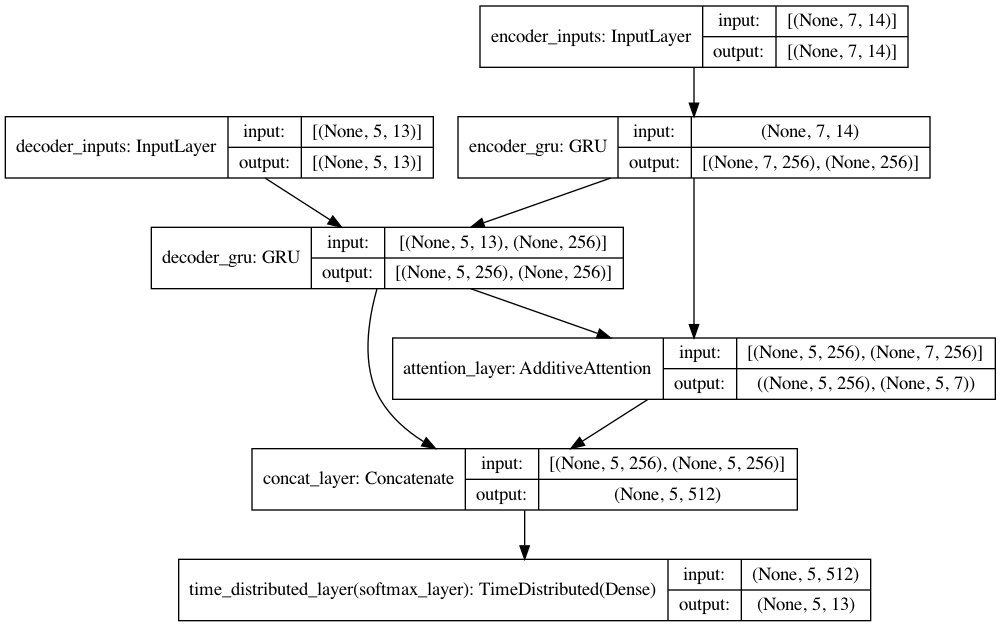

In [40]:
plot_model(full_model5, show_shapes=True)

### Training

In [41]:
# Run training
full_model5.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
history5 = full_model5.fit([encoder_input_onehot, decoder_input_onehot],
                           decoder_output_onehot,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_split=0.2)

Epoch 1/10
282/282 [==============================] - 19s 55ms/step - loss: 1.7151 - accuracy: 0.4074 - val_loss: 1.3796 - val_accuracy: 0.4807
Epoch 2/10
282/282 [==============================] - 14s 51ms/step - loss: 1.3529 - accuracy: 0.4943 - val_loss: 1.2292 - val_accuracy: 0.5336
Epoch 3/10
282/282 [==============================] - 14s 49ms/step - loss: 1.1731 - accuracy: 0.5576 - val_loss: 1.0490 - val_accuracy: 0.6043
Epoch 4/10
282/282 [==============================] - 14s 50ms/step - loss: 1.0188 - accuracy: 0.6134 - val_loss: 0.9334 - val_accuracy: 0.6438
Epoch 5/10
282/282 [==============================] - 14s 50ms/step - loss: 0.8974 - accuracy: 0.6582 - val_loss: 0.8127 - val_accuracy: 0.6915
Epoch 6/10
282/282 [==============================] - 14s 51ms/step - loss: 0.7851 - accuracy: 0.7042 - val_loss: 0.7356 - val_accuracy: 0.7190
Epoch 7/10
282/282 [==============================] - 14s 51ms/step - loss: 0.7099 - accuracy: 0.7339 - val_loss: 0.6726 - val_accuracy:

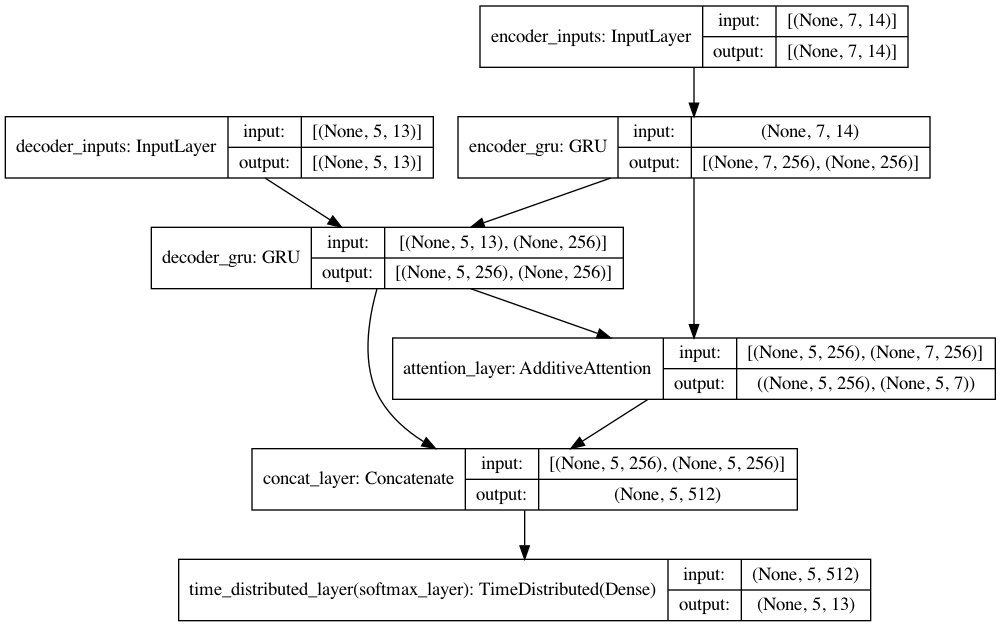

In [42]:
plot_model(full_model5, show_shapes=True)

## Save Models

In [43]:
# # Save model
full_model5.save('keras_models/s2s-addition-attention.h5')

## Interim Comparison

In [44]:
history = [history1, history2, history3, history4, history5]
history = [i.history for i in history]
model_names = ['VanilaRNN', 'GRU', 'Birdirectional', 'Peeky', 'Attention']

In [45]:
import pickle

with open('keras_models/s2s-attention-addition-history', 'wb') as f:
    pickle.dump(history, f)

In [46]:
with open('keras_models/s2s-attention-addition-history', 'rb') as f:
    history = pickle.load(f)

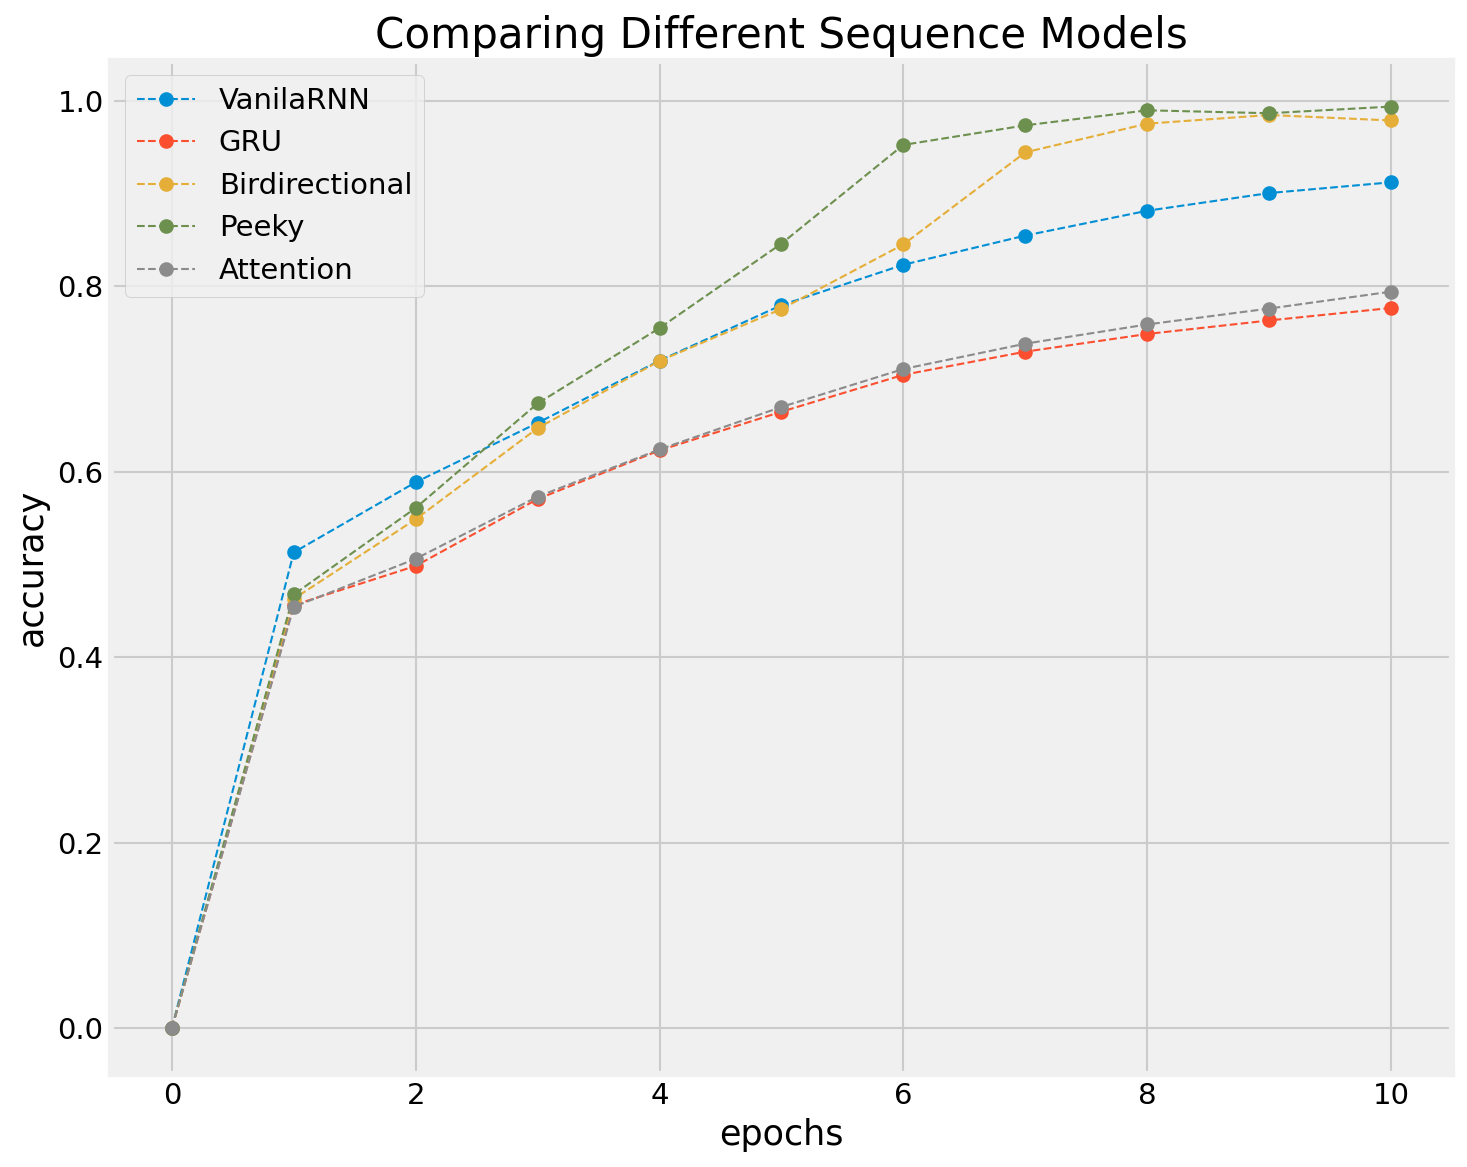

In [47]:
acc = [i['accuracy'] for i in history]
val_acc = [i['val_accuracy'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('fivethirtyeight')
for i, a in enumerate(acc):
    plt.plot(range(len(a) + 1), [0] + a,
             linestyle='--',
             marker='o',
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

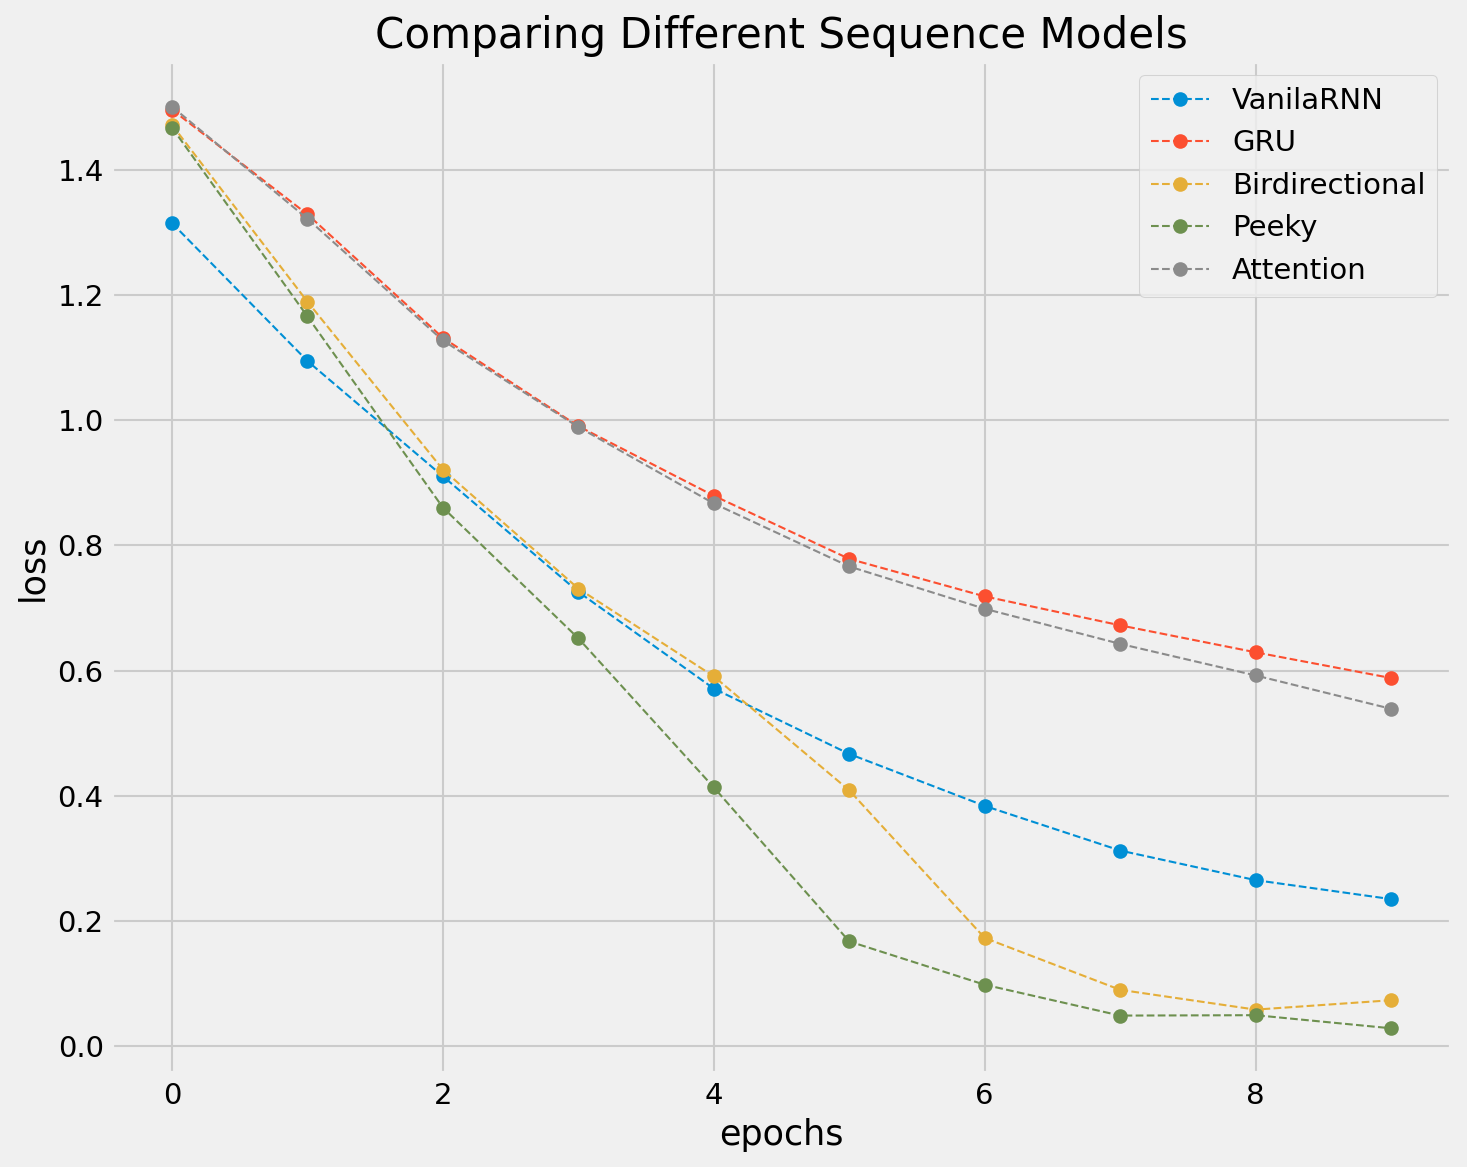

In [48]:
loss = [i['loss'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('fivethirtyeight')
for i, a in enumerate(loss):
    plt.plot(range(len(a)),
             a,
             linestyle='--',
             marker='o',
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.show()

## Attention Model Analysis

In [49]:
# ## If the model is loaded via external files
# ## Load the encoder_model, decoder_model this way
# from keras.models import load_model
# full_model5.load_weights('keras_models/s2s-addition-attention.h5')
# full_model5.compile(optimizer='adam',
#                     loss='categorical_crossentropy',
#                     metrics=['accuracy'])

In [50]:
full_model = full_model5

## Inference 

### Inference Encoder

In [51]:
""" Inference model """
""" Encoder (Inference) model """
encoder_inf_inputs = full_model.input[0]
encoder_inf_out, encoder_inf_state = full_model.layers[2].output
encoder_inf_model = Model(inputs=encoder_inf_inputs,
                          outputs=[encoder_inf_out, encoder_inf_state])

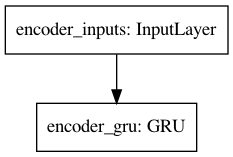

In [52]:
plot_model(encoder_inf_model)

### Inference Decoder

- The attention weights refer to at each time step, the relevance of the decoder output h and all the encoder output h's. Therefore, the shape of the attention weights should be `(input_maxlen,)`

In [53]:
""" Decoder (Inference) model """
decoder_inf_inputs = Input(
    shape=(1, target_vsize),
    name='decoder_inf_inputs')  ## first target charcater
encoder_inf_states = Input(
    shape=(input_maxlen, latent_dim),
    name='encoder_inf_states')  ## initial h's from encoder
decoder_init_state = Input(shape=(latent_dim),
                           name='decoder_init')  ## initial c from encoder

decoder_inf_gru = full_model.layers[3]
decoder_inf_out, decoder_inf_state = decoder_inf_gru(
    decoder_inf_inputs, initial_state=decoder_init_state)
# attn_inf_out, attn_inf_weights = attn_layer([encoder_inf_states, decoder_inf_out])
decoder_inf_attention = full_model.layers[4]
attn_inf_out, attn_inf_weights = decoder_inf_attention(
    [decoder_inf_out, encoder_inf_states], return_attention_scores=True)

decoder_inf_concat = Concatenate(
    axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
decoder_inf_timedense = full_model.layers[6]
decoder_inf_pred = decoder_inf_timedense(decoder_inf_concat)
decoder_inf_model = Model(
    inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
    outputs=[decoder_inf_pred, attn_inf_weights, decoder_inf_state])

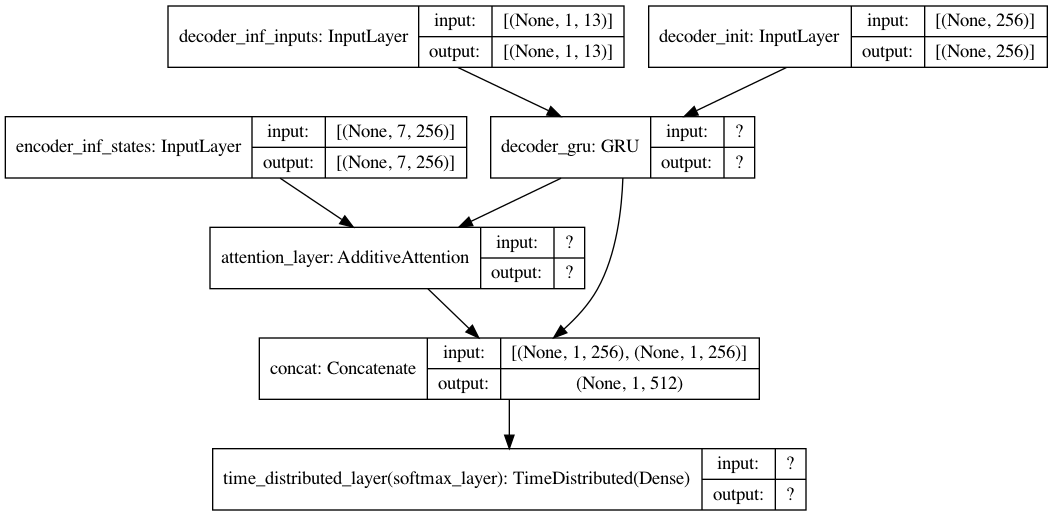

In [54]:
plot_model(decoder_inf_model, show_shapes=True)

In [55]:
def decode_sequence(input_seq):

    ## Initialize target output character "_"
    #     test_dec_onehot_seq = np.zeros((1,1,target_vsize))
    #     test_dec_onehot_seq[0,0, target_tokenizer.word_index.get('_')]=1.0
    initial_text = ['_']
    initial_seq = target_tokenizer.texts_to_sequences([initial_text])
    #initial_seq = pad_sequences(initial_seq, padding='post', maxlen = target_maxlen)
    test_dec_onehot_seq = np.expand_dims(
        to_categorical(initial_seq, num_classes=target_vsize), 1)

    ## Encoder Inference
    enc_outs, enc_last_state = encoder_inf_model.predict(input_seq)

    ## Update decoder initial state
    dec_state = enc_last_state

    ## Holder for attention weights and decoded texts
    attention_weights = []
    dec_text = ''

    for i in range(target_maxlen):
        dec_out, attention, dec_state = decoder_inf_model.predict(
            [enc_outs, dec_state, test_dec_onehot_seq])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

        if dec_ind == 0:
            break


#         test_dec_onehot_seq = np.zeros((1,1,target_vsize))
#         test_dec_onehot_seq[0,0, dec_ind]=1.0
        initial_text = [dec_index2word[dec_ind]]
        initial_seq = target_tokenizer.texts_to_sequences([initial_text])
        #initial_seq = pad_sequences(initial_seq, padding='post', maxlen = target_maxlen)
        test_dec_onehot_seq = np.expand_dims(
            to_categorical(initial_seq, num_classes=target_vsize), 1)

        attention_weights.append((dec_ind, attention))

        ## append the predicted char
        dec_text += dec_index2word[dec_ind]

    return dec_text, attention_weights

In [56]:
decoder_input_onehot[0:1, :, :]

array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
      dtype=float32)

In [57]:
encoder_input_onehot[0:10, :, :].shape

(10, 7, 14)

In [58]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    decoded_sentence, _ = decode_sequence(
        encoder_input_onehot[seq_index:seq_index + 1, :, :])
    print('-')
    print('Input sentence:', tr_input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: 27+673 
Decoded sentence: 698_
-
Input sentence: 153+27 
Decoded sentence: 182_
-
Input sentence: 93+901 
Decoded sentence: 995_
-
Input sentence: 243+678
Decoded sentence: 921_
-
Input sentence: 269+46 
Decoded sentence: 312_
-
Input sentence: 235+891
Decoded sentence: 1125_
-
Input sentence: 46+290 
Decoded sentence: 337_
-
Input sentence: 324+947
Decoded sentence: 1270_
-
Input sentence: 721+49 
Decoded sentence: 770_
-
Input sentence: 535+7  
Decoded sentence: 541_
-
Input sentence: 45+117 
Decoded sentence: 161_
-
Input sentence: 669+174
Decoded sentence: 836_
-
Input sentence: 904+7  
Decoded sentence: 911_
-
Input sentence: 22+731 
Decoded sentence: 752_
-
Input sentence: 83+742 
Decoded sentence: 821_
-
Input sentence: 808+769
Decoded sentence: 1572_
-
Input sentence: 240+42 
Decoded sentence: 282_
-
Input sentence: 18+44  
Decoded sentence: 61_
-
Input sentence: 4+166  
Decoded sentence: 167_
-
Input sentence: 731+13 
Decoded sentence: 749_


## Plotting Attention

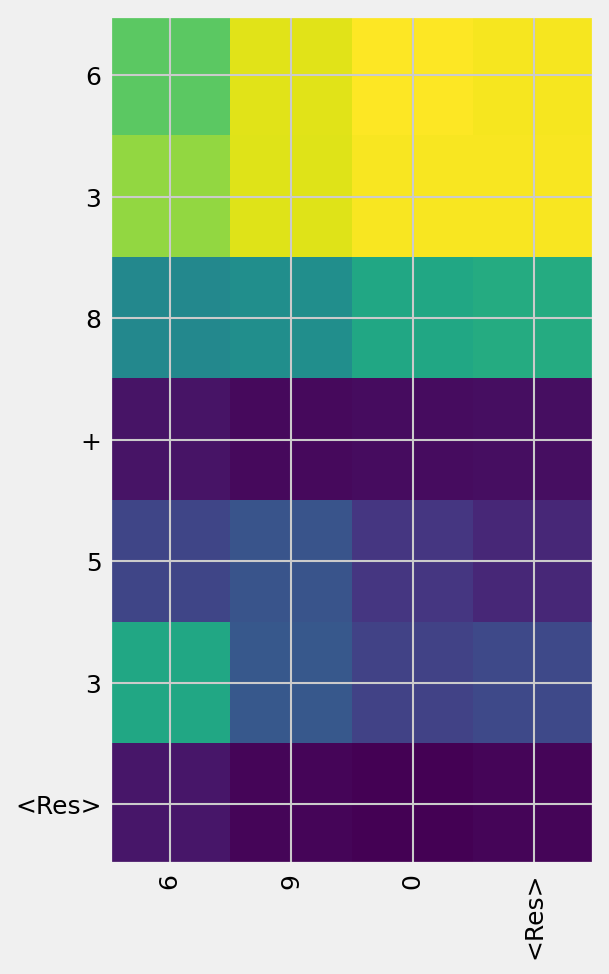

In [59]:
ind = 400
doc_inputs, attention_weights = decode_sequence(encoder_input_onehot[ind:ind +
                                                                     1, :, :])
mats = []
dec_inputs = []
for dec_ind, attn in attention_weights:
    mats.append(attn.reshape(-1))
    dec_inputs.append(dec_ind)
attention_mat = np.transpose(np.array(mats))
fig, ax = plt.subplots(figsize=(5, 7))
ax.imshow(attention_mat)

ax.set_xticks(np.arange(attention_mat.shape[1]))
ax.set_yticks(np.arange(attention_mat.shape[0]))

ax.set_xticklabels(
    [dec_index2word[inp] if inp != 2 else "<Res>" for inp in dec_inputs])
ax.set_yticklabels([
    enc_index2word[inp] if inp != 2 else "<Res>"
    for inp in encoder_input_sequences[ind]
])

ax.tick_params(labelsize=12)
ax.tick_params(axis='x', labelrotation=90)

## Evaluation on Testing Data

- Wrap data preprocessing in a function

In [60]:
def preprocess_data(enc_tokenizer, dec_tokenizer, enc_text, dec_text,
                    enc_maxlen, dec_maxlen, enc_vsize, dec_vsize):
    enc_seq = enc_tokenizer.texts_to_sequences(enc_text)
    enc_seq = pad_sequences(enc_seq, padding='post', maxlen=enc_maxlen)
    enc_onehot = to_categorical(enc_seq, num_classes=enc_vsize)

    dec_seq = dec_tokenizer.texts_to_sequences(dec_text)
    dec_seq = pad_sequences(dec_seq, padding='post', maxlen=dec_maxlen)
    dec_onehot = to_categorical(dec_seq, num_classes=dec_vsize)
    return enc_onehot, dec_onehot

In [61]:
ts_encoder_input_onehot, ts_decoder_target_onehot = preprocess_data(
    input_tokenizer, target_tokenizer, ts_input_texts, ts_target_texts,
    input_maxlen, target_maxlen, input_vsize, target_vsize)

In [62]:
print(ts_encoder_input_onehot.shape)
print(ts_decoder_target_onehot.shape)

(5000, 7, 14)
(5000, 6, 13)


In [63]:
full_model.evaluate(
    [ts_encoder_input_onehot, ts_decoder_target_onehot[:, :-1, :]],
    ts_decoder_target_onehot[:, 1:, :],
    batch_size=batch_size,
    verbose=2)

40/40 - 1s - loss: 0.5189 - accuracy: 0.7970


[0.5189342498779297, 0.7970399856567383]

## References

- [Attention? Attention!](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)
- Bahdanau Attention Layber developed in [Thushan](https://github.com/thushv89/attention_keras)
- Thushan Ganegedara's [Attention in Deep Networks with Keras](https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39)
- This is based on Chapter 7 of [Deep Learning 2用 Python 進行自然語言處理的基礎理論實作](https://www.tenlong.com.tw/products/9789865020675)